* **Author**: Andrea Ziqing Gallardo Bendito

* **Project**: Bachelor Thesis - *Separación de fuentes musicales en conjuntos de cámara de música clásica*

* **GitHub Repo**: [MusicSourceSep](https://github.com/andrezg98/MusicSourceSep)

In this Notebook we are going to generate training data for music source separation on the fly using the [Scaper python library](https://github.com/justinsalamon/scaper) based on this [tutorial](https://source-separation.github.io/tutorial/data/scaper.html#generating-data) and train the *Mask Inference* model implemented by the [Nussl](https://nussl.github.io/docs/) library created by [Interactive Audio Lab](https://interactiveaudiolab.github.io/).



---



## **Project repository download and Library installations**

In [1]:
!pip install scaper -q
!pip install nussl -q
!pip install git+https://github.com/source-separation/tutorial -q

     |████████████████████████████████| 3.3 MB 20.0 MB/s 
     |████████████████████████████████| 51 kB 53 kB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 87 kB 5.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.5.4 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which is incompatible.
     |████████████████████████████████| 239 kB 12.7 MB/s 
     |████████████████████████████████| 143 kB 71.6 MB/s 
     |████████████████████████████████| 498 kB 66.9 MB/s 
     |████████████████████████████████| 232 kB 70.7 MB/s 
     |████████████████████████████████| 963 kB 63.3 MB/s 
     |████████████████████████████████| 129 kB 70.2 MB/s 
     |████████████████████████████████| 6.3 MB 69.3 MB/s 
     |████████████████████████████████| 42 kB 791 kB/s 
     |████████████████████████████

### **Imports**

To keep things clean we'll hide all warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Imports
import numpy as np
import librosa
import torch
import pandas as pd
import os
import glob
from scipy.io.wavfile import write
from IPython.display import Audio, display
from google.colab import files
from pathlib import Path
import shutil
import json
import matplotlib.pyplot as plt

# Scaper
import scaper

# Nussl
import nussl
from nussl.datasets import transforms as nussl_tfm
from nussl.datasets import hooks
from common.models import MaskInference
from common import utils, data
from common import viz

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [ ]:
# !pip list

### **Project repository download**

In [ ]:
# from getpass import getpass

# # IMPORTANT: ¡Change when publishing the repository!

# user = 'andrezg98'
# password = getpass('GitHub repo password')
# u = user; p = password; 
# !git clone https://$u:$p@github.com/$u/MusicSourceSep.git
# %cd MusicSourceSep/lib
# !ls

# del p, password

GitHub repo password··········
Cloning into 'MusicSourceSep'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 68 (delta 19), reused 21 (delta 4), pack-reused 0
Unpacking objects: 100% (68/68), done.
/content/drive/MyDrive/ING. SONIDO E IMAGEN/TFG/Preview Tests/Datasets/URMP-Dataset/MusicSourceSep/lib
feature_computation.py	urmp_dataset.py


## **Datasets**

Access to the Datasets folder

* **Bach10 Dataset**
  
    Accessing the dataset stored in my Google Drive:

In [4]:
%cd /content/drive/MyDrive/ING. SONIDO E IMAGEN/TFG/Datasets

/content/drive/MyDrive/ING. SONIDO E IMAGEN/TFG/Datasets


In [ ]:
# %cd Bach10_nussl/

/content/drive/MyDrive/ING. SONIDO E IMAGEN/TFG/Datasets/Bach10_nussl


In [ ]:
# tr_val_test = ['train', 'valid', 'test']
# sources = ['bassoon', 'clarinet', 'mix', 'saxphone', 'violin']
# for i in range(10):
#   dataset_folder = f"Bach10_nussl_leaveSong{i+1}"
#   if not os.path.exists(dataset_folder):
#         os.makedirs(dataset_folder)
#   for n in tr_val_test:
#     tr_val_test_folders = f"Bach10_nussl_leaveSong{i+1}/{n}"
#     if not os.path.exists(tr_val_test_folders):
#         os.makedirs(tr_val_test_folders)
#     for s in sources:
#       sources_folder = f"Bach10_nussl_leaveSong{i+1}/{n}/{s}"
#       if not os.path.exists(sources_folder):
#           os.makedirs(sources_folder)



---



##  **Preparing the source material for training**

Assign the path of the foreground and background folders to each variable

In [ ]:
# %cd Bach10/

/content/drive/MyDrive/ING. SONIDO E IMAGEN/TFG/Datasets/Bach10_v1.1


In [ ]:
# fg_folder = Path("../Bach10_Scaper/foreground")
# bg_folder = Path("../Bach10_Scaper/background")



---



## **Plugging Scaper into nussl: generating training data on-the-fly**

In [5]:
# Create a template of probabilistic event parameters
template_event_parameters = {
    'label': ('const', 'bassoon'),           # set the label value explicitly using a constant
    'source_file': ('choose', []),           # choose the source file randomly from all files in the folder
    'source_time': ('uniform', 0, 7),        # sample the source (stem) audio starting at a time between 0-7
    'event_time': ('const', 0),              # always add the stem at time 0 in the mixture
    'event_duration': ('const', 25.0),       # set the stem duration to match the mixture duration
    'snr': ('uniform', -5, 5),               # choose an SNR for the stem uniformly between -5 and 5 dB
    'pitch_shift': ('uniform', -2, 2),       # apply a random pitch shift between -2 and 2 semitones
    'time_stretch': ('uniform', 0.8, 1.2)    # apply a random time stretch between 0.8 (faster) and 1.2 (slower)
}

In [6]:
def coherent(fg_folder, bg_folder, event_template, seed):
    """
    This function takes the paths to the dataset folders and a random seed,
    and returns a COHERENT mixture (audio + annotations).
    
    Parameters
    ----------
    fg_folder : str
        Path to the foreground source material for Bach10
    bg_folder : str
        Path to the background material for Bach10 (empty folder)
    event_template: dict
        Dictionary containing a template of probabilistic event parameters
    seed : int or np.random.RandomState()
        Seed for setting the Scaper object's random state. Different seeds will 
        generate different mixtures for the same source material and event template.
        
    Returns
    -------
    mixture_audio : np.ndarray
        Audio signal for the mixture
    mixture_jams : np.ndarray
        JAMS annotation for the mixture
    annotation_list : list
        Simple annotation in list format
    stem_audio_list : list
        List containing the audio signals of the stems that comprise the mixture
    """
        
    # Create scaper object and seed random state
    sc = scaper.Scaper(
        duration=template_event_parameters["event_duration"][1],
        fg_path=str(fg_folder),
        bg_path=str(bg_folder),
        random_state=seed
    )
    
    # Set sample rate, reference dB, and channels (mono)
    sc.sr = 44100
    sc.ref_db = -20
    sc.n_channels = 1
    
    # Copy the template so we can change it
    event_parameters = event_template.copy()    
    
    # Instatiate the template once to randomly choose a song,   
    # a start time for the sources, a pitch shift and a time    
    # stretch. These values must remain COHERENT across all stems
    sc.add_event(**event_parameters)
    event = sc._instantiate_event(sc.fg_spec[0])
    
    # Reset the Scaper object's the event specification
    sc.reset_fg_event_spec()
    
    # Replace the distributions for source time, pitch shift and 
    # time stretch with the constant values we just sampled, to  
    # ensure our added events (stems) are coherent.              
    event_parameters['source_time'] = ('const', event.source_time)
    event_parameters['pitch_shift'] = ('const', event.pitch_shift)
    event_parameters['time_stretch'] = ('const', event.time_stretch)

    # Iterate over the four stems (vocals, drums, bass, other) and 
    # add COHERENT events.                                         
    labels = ['bassoon', 'clarinet', 'saxphone', 'violin']
    for label in labels:
        
        # Set the label to the stem we are adding
        event_parameters['label'] = ('const', label)
        
        # To ensure coherent source files (all from the same song), we leverage
        # the fact that all the stems from the same song have the same filename.
        # All we have to do is replace the stem file's parent folder name from "bassoon" 
        # to the label we are adding in this iteration of the loop, which will give the 
        # correct path to the stem source file for this current label.
        coherent_source_file = event.source_file.replace('bassoon', label)
        # print(coherent_source_file)
        event_parameters['source_file'] = ('const', coherent_source_file)
        
        # Add the event using the modified, COHERENT, event parameters
        sc.add_event(**event_parameters)
    
    # Generate and return the mixture audio, stem audio, and annotations
    return sc.generate(fix_clipping=True)

In [7]:
def generate_mixture(dataset, fg_folder, bg_folder, event_template, seed):
    
    # hide warnings
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        
        # flip a coint to choose coherent or incoherent mixing
        random_state = np.random.RandomState(seed)
        
        # generate mixture
        data = coherent(fg_folder, bg_folder, event_template, seed)
            
    # unpack the data
    mixture_audio, mixture_jam, annotation_list, stem_audio_list = data
    
    # convert mixture to nussl format
    mix = dataset._load_audio_from_array(
        audio_data=mixture_audio, sample_rate=dataset.sample_rate
    )
    
    # convert stems to nussl format
    sources = {}
    ann = mixture_jam.annotations.search(namespace='scaper')[0]
    for obs, stem_audio in zip(ann.data, stem_audio_list):
        key = obs.value['label']
        sources[key] = dataset._load_audio_from_array(
            audio_data=stem_audio, sample_rate=dataset.sample_rate
        )
    
    # store the mixture, stems and JAMS annotation in the format expected by nussl
    output = {
        'mix': mix,
        'sources': sources,
        'metadata': mixture_jam
    }
    return output

In [8]:
# Convenience class so we don't need to enter the fg_folder, bg_folder, and template each time
class MixClosure:
    
    def __init__(self, fg_folder, bg_folder, event_template):
        self.fg_folder = fg_folder
        self.bg_folder = bg_folder
        self.event_template = event_template
        
    def __call__(self, dataset, seed):
        return generate_mixture(dataset, self.fg_folder, self.bg_folder, self.event_template, seed)



---



## **Model Implementation: Bach10 Dataset**

**Max mixtures**: 10/song

> *   Train: 80
*   Validation: 10
*   Test: 1





In [ ]:
# %cd ..
# !ls

/content/drive/MyDrive/ING. SONIDO E IMAGEN/TFG/Datasets
 Bach10		 dsd100-Dataset      MUSDB18WAV
 Bach10_nussl	 EEP-Dataset	    'PHENICX(Anechoic)-Dataset'
 Bach10_Scaper	 ISMIR-Database128   RandomAudio
 Bach10_v1.1	 MUSDB18	     URMP-Dataset


In [9]:
!rm -rf '/root/.nussl'
!mkdir '/root/.nussl'

# songs = [1, 2, 3, 4, 5]
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong1 /root/.nussl/Bach10_nussl_leaveSong1
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong2 /root/.nussl/Bach10_nussl_leaveSong2
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong3 /root/.nussl/Bach10_nussl_leaveSong3
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong4 /root/.nussl/Bach10_nussl_leaveSong4
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong5 /root/.nussl/Bach10_nussl_leaveSong5

songs = [6, 7, 8, 9, 10]
!cp -r Bach10_nussl/Bach10_nussl_leaveSong6 /root/.nussl/Bach10_nussl_leaveSong6
!cp -r Bach10_nussl/Bach10_nussl_leaveSong7 /root/.nussl/Bach10_nussl_leaveSong7
!cp -r Bach10_nussl/Bach10_nussl_leaveSong8 /root/.nussl/Bach10_nussl_leaveSong8
!cp -r Bach10_nussl/Bach10_nussl_leaveSong9 /root/.nussl/Bach10_nussl_leaveSong9
!cp -r Bach10_nussl/Bach10_nussl_leaveSong10 /root/.nussl/Bach10_nussl_leaveSong10

# songs = [1, 2]
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong1 /root/.nussl/Bach10_nussl_leaveSong1
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong2 /root/.nussl/Bach10_nussl_leaveSong2

# songs = [3, 4]
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong3 /root/.nussl/Bach10_nussl_leaveSong3
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong4 /root/.nussl/Bach10_nussl_leaveSong4

# songs = [5, 6]
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong5 /root/.nussl/Bach10_nussl_leaveSong5
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong6 /root/.nussl/Bach10_nussl_leaveSong6

# songs = [7, 8]
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong7 /root/.nussl/Bach10_nussl_leaveSong7
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong8 /root/.nussl/Bach10_nussl_leaveSong8

# songs = [9, 10]
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong9 /root/.nussl/Bach10_nussl_leaveSong9
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong10 /root/.nussl/Bach10_nussl_leaveSong10

In [10]:
# Example
!ls -ll /root/.nussl/Bach10_nussl_leaveSong6/train/bassoon

total 22876
-rw------- 1 root root 2225034 Aug 30 18:32 01-AchGottundHerr.wav
-rw------- 1 root root 3575308 Aug 30 18:32 02-AchLiebenChristen.wav
-rw------- 1 root root 2237090 Aug 30 18:32 03-ChristederdubistTagundLicht.wav
-rw------- 1 root root 3674910 Aug 30 18:32 04-ChristeDuBeistand.wav
-rw------- 1 root root 2872398 Aug 30 18:32 07-HerrGott.wav
-rw------- 1 root root 2931704 Aug 30 18:32 08-FuerDeinenThron.wav
-rw------- 1 root root 2589188 Aug 30 18:32 09-Jesus.wav
-rw------- 1 root root 3297950 Aug 30 18:32 10-NunBitten.wav


Data generation:

In [11]:
utils.logger()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using: {DEVICE}")

# MAX_MIXTURES = 1
MAX_MIXTURES = 10

instruments = ['violin', 'bassoon', 'clarinet', 'saxphone']

sum_sources = {'violin': [['bassoon', 'clarinet', 'saxphone']],
               'bassoon': [['clarinet', 'saxphone', 'violin']],
               'clarinet': [['bassoon', 'saxphone', 'violin']],
               'saxphone': [['bassoon', 'clarinet', 'violin']]}

stft_params = nussl.STFTParams(window_length=512, hop_length=128)

train_data = {}
train_dataloader = {}
val_data = {}
val_dataloader = {}

for song in songs:
    train_folder = f"~/.nussl/Bach10_nussl_leaveSong{song}/train"
    val_folder = f"~/.nussl/Bach10_nussl_leaveSong{song}/valid"

    song_index = "song"+str(song)
    train_data[song_index], train_dataloader[song_index] = {}, {}
    val_data[song_index], val_dataloader[song_index] = {}, {}

    for target_instrument in instruments:
        print(f"Creating dataloader for Target instrument: {target_instrument} - separated from: {sum_sources[target_instrument]}.")

        tfm = nussl_tfm.Compose([
            nussl_tfm.SumSources(sum_sources[target_instrument]),
            nussl_tfm.MagnitudeSpectrumApproximation(),
            nussl_tfm.IndexSources('source_magnitudes', 1),
            nussl_tfm.ToSeparationModel(),
        ])

        mix_func_train = MixClosure(train_folder, train_folder, template_event_parameters)
        mix_func_val = MixClosure(val_folder, val_folder, template_event_parameters)
        

        train_data[song_index][target_instrument] = nussl.datasets.OnTheFly(mix_func_train, 
                                                                num_mixtures=MAX_MIXTURES, 
                                                                stft_params=stft_params, 
                                                                transform=tfm, 
                                                                sample_rate=44100)
        train_dataloader[song_index][target_instrument] = torch.utils.data.DataLoader(train_data[song_index][target_instrument], 
                                                                          num_workers=1, 
                                                                          batch_size=5)

        val_data[song_index][target_instrument] = nussl.datasets.OnTheFly(mix_func_val, 
                                                              num_mixtures=MAX_MIXTURES, 
                                                              stft_params=stft_params, 
                                                              transform=tfm, 
                                                              sample_rate=44100)
        val_dataloader[song_index][target_instrument] = torch.utils.data.DataLoader(val_data[song_index][target_instrument], 
                                                                        num_workers=1, 
                                                                        batch_size=5)

Using: cpu
Creating dataloader for Target instrument: violin - separated from: [['bassoon', 'clarinet', 'saxphone']].
Creating dataloader for Target instrument: bassoon - separated from: [['clarinet', 'saxphone', 'violin']].
Creating dataloader for Target instrument: clarinet - separated from: [['bassoon', 'saxphone', 'violin']].
Creating dataloader for Target instrument: saxphone - separated from: [['bassoon', 'clarinet', 'violin']].
Creating dataloader for Target instrument: violin - separated from: [['bassoon', 'clarinet', 'saxphone']].
Creating dataloader for Target instrument: bassoon - separated from: [['clarinet', 'saxphone', 'violin']].
Creating dataloader for Target instrument: clarinet - separated from: [['bassoon', 'saxphone', 'violin']].
Creating dataloader for Target instrument: saxphone - separated from: [['bassoon', 'clarinet', 'violin']].
Creating dataloader for Target instrument: violin - separated from: [['bassoon', 'clarinet', 'saxphone']].
Creating dataloader for Ta

Example:

In [12]:
train_data

{'song10': {'bassoon': <nussl.datasets.hooks.OnTheFly at 0x7f1e428c45d0>,
  'clarinet': <nussl.datasets.hooks.OnTheFly at 0x7f1e428c4f90>,
  'saxphone': <nussl.datasets.hooks.OnTheFly at 0x7f1e428b1b50>,
  'violin': <nussl.datasets.hooks.OnTheFly at 0x7f1e428c44d0>},
 'song6': {'bassoon': <nussl.datasets.hooks.OnTheFly at 0x7f1e443263d0>,
  'clarinet': <nussl.datasets.hooks.OnTheFly at 0x7f1e44331e50>,
  'saxphone': <nussl.datasets.hooks.OnTheFly at 0x7f1e42888c90>,
  'violin': <nussl.datasets.hooks.OnTheFly at 0x7f1e44331a10>},
 'song7': {'bassoon': <nussl.datasets.hooks.OnTheFly at 0x7f1e428865d0>,
  'clarinet': <nussl.datasets.hooks.OnTheFly at 0x7f1e4289e390>,
  'saxphone': <nussl.datasets.hooks.OnTheFly at 0x7f1e428a2550>,
  'violin': <nussl.datasets.hooks.OnTheFly at 0x7f1e42886ad0>},
 'song8': {'bassoon': <nussl.datasets.hooks.OnTheFly at 0x7f1e428a2ad0>,
  'clarinet': <nussl.datasets.hooks.OnTheFly at 0x7f1e428a0310>,
  'saxphone': <nussl.datasets.hooks.OnTheFly at 0x7f1e428b0d

In [13]:
train_dataloader

{'song10': {'bassoon': <torch.utils.data.dataloader.DataLoader at 0x7f1e428b1090>,
  'clarinet': <torch.utils.data.dataloader.DataLoader at 0x7f1e428c4790>,
  'saxphone': <torch.utils.data.dataloader.DataLoader at 0x7f1e428b1a10>,
  'violin': <torch.utils.data.dataloader.DataLoader at 0x7f1e428a0550>},
 'song6': {'bassoon': <torch.utils.data.dataloader.DataLoader at 0x7f1e4432ee10>,
  'clarinet': <torch.utils.data.dataloader.DataLoader at 0x7f1e44331a50>,
  'saxphone': <torch.utils.data.dataloader.DataLoader at 0x7f1e42888210>,
  'violin': <torch.utils.data.dataloader.DataLoader at 0x7f1e4430fad0>},
 'song7': {'bassoon': <torch.utils.data.dataloader.DataLoader at 0x7f1e42886a90>,
  'clarinet': <torch.utils.data.dataloader.DataLoader at 0x7f1e42886110>,
  'saxphone': <torch.utils.data.dataloader.DataLoader at 0x7f1e428a2d90>,
  'violin': <torch.utils.data.dataloader.DataLoader at 0x7f1e42888dd0>},
 'song8': {'bassoon': <torch.utils.data.dataloader.DataLoader at 0x7f1e428a0490>,
  'clari

**Mask Estimation Model**
```
class MaskInference(nn.Module):
...
def build(num_features, num_audio_channels, hidden_size, 
              num_layers, bidirectional, dropout, num_sources, 
              activation='sigmoid'):
```



In [14]:
# model params
nf = stft_params.window_length // 2 + 1
n_audio_channels = 1
hidden_size = 50
num_layers = 2
bidirectional = True
dropout = 0.2
num_sources = 1
activation = 'sigmoid'

# train params
lr = 1e-3
epoch_length = 10
max_epochs = 1

In [15]:
model = MaskInference.build(nf, 
                            n_audio_channels, 
                            hidden_size, 
                            num_layers, 
                            bidirectional, 
                            dropout, 
                            num_sources, 
                            activation)

model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr)

loss_fn = nussl.ml.train.loss.L1Loss()

In [16]:
def train_step(engine, batch):
    optimizer.zero_grad()
    output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )
    
    loss.backward() # backwards + gradient step
    optimizer.step()
    
    loss_vals = {
        'L1Loss': loss.item(),
        'loss': loss.item()
    }
    
    return loss_vals

def val_step(engine, batch):
    with torch.no_grad():
        output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )    
    loss_vals = {
        'L1Loss': loss.item(), 
        'loss': loss.item()
    }
    return loss_vals

Training:

In [ ]:
for song in songs:
    for target_instrument in instruments:
        print(f"================================\n{target_instrument} Separator Model Training\n================================")
        # Create the engine trainer for each target instrument separator model
        trainer, validator = nussl.ml.train.create_train_and_validation_engines(
                                  train_step, val_step, device=DEVICE)

        # We'll save the output relative to this notebook.
        model_config_str = f"SepModel_{target_instrument}_MaxMix={MAX_MIXTURES}_HSize={hidden_size}_NLayers={num_layers}_Dropout={dropout}_EpcLen={epoch_length}_MaxEpc={max_epochs}"
        model_dirName = f"Bach10_nussl/models/leaveSong{song}/"+model_config_str

        if not os.path.exists(model_dirName):
            os.makedirs(model_dirName)
            print("Directory " , model_dirName ,  " Created ")

        output_folder = Path(model_dirName).absolute()

        # Adding handlers from nussl that print out details about model training
        # run the validation step, and save the models.

        song_index = "song"+str(song)

        nussl.ml.train.add_stdout_handler(trainer, validator)
        nussl.ml.train.add_validate_and_checkpoint(output_folder, model, 
                                                  optimizer, train_data[song_index][target_instrument], 
                                                  trainer, val_dataloader[song_index][target_instrument], 
                                                  validator)
        
        trainer.run(train_dataloader[song_index][target_instrument], 
                    epoch_length=epoch_length, 
                    max_epochs=max_epochs)

violin Separator Model Training


08/30/2021 06:38:31 PM | engine.py:693 Engine run starting with max_epochs=1.


Directory  Bach10_nussl/models/leaveSong6/SepModel_violin_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1  Created 


08/30/2021 06:42:33 PM | engine.py:693 Engine run starting with max_epochs=1.
08/30/2021 06:43:12 PM | engine.py:756 Epoch[1] Complete. Time taken: 00:00:39
08/30/2021 06:43:12 PM | engine.py:769 Engine run complete. Time taken: 00:00:39
08/30/2021 06:43:12 PM | trainer.py:311 

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0001 / 0001 
- Training loss:   0.000635 
- Validation loss: 0.000561 
- Epoch took: 0:04:41.381978 
- Time since start: 0:04:41.382095 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to /content/drive/My Drive/ING. SONIDO E IMAGEN/TFG/Datasets/Bach10_nussl/models/leaveSong6/SepModel_violin_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1/checkpoints/best.model.pth. 
Output @ /content/drive/My Drive/ING. SONIDO E IMAGEN/TFG/Datasets/Bach10_nussl/models/leaveSong6/SepModel_violin_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1 

08/30/2021 06:43:12 PM | engine.py:756 Epoch[1] Complete. Time taken: 00:04:41
08/30/2021 06:43:12 PM | engi

bassoon Separator Model Training
Directory  Bach10_nussl/models/leaveSong6/SepModel_bassoon_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1  Created 


08/30/2021 06:47:16 PM | engine.py:693 Engine run starting with max_epochs=1.
08/30/2021 06:47:55 PM | engine.py:756 Epoch[1] Complete. Time taken: 00:00:39
08/30/2021 06:47:55 PM | engine.py:769 Engine run complete. Time taken: 00:00:39
08/30/2021 06:47:55 PM | trainer.py:311 

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0001 / 0001 
- Training loss:   0.000779 
- Validation loss: 0.000702 
- Epoch took: 0:04:42.275325 
- Time since start: 0:04:42.275471 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to /content/drive/My Drive/ING. SONIDO E IMAGEN/TFG/Datasets/Bach10_nussl/models/leaveSong6/SepModel_bassoon_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1/checkpoints/best.model.pth. 
Output @ /content/drive/My Drive/ING. SONIDO E IMAGEN/TFG/Datasets/Bach10_nussl/models/leaveSong6/SepModel_bassoon_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1 

08/30/2021 06:47:55 PM | engine.py:756 Epoch[1] Complete. Time taken: 00:04:42
08/30/2021 06:47:55 PM | en

clarinet Separator Model Training
Directory  Bach10_nussl/models/leaveSong6/SepModel_clarinet_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1  Created 


08/30/2021 06:52:01 PM | engine.py:693 Engine run starting with max_epochs=1.
08/30/2021 06:52:41 PM | engine.py:756 Epoch[1] Complete. Time taken: 00:00:39
08/30/2021 06:52:41 PM | engine.py:769 Engine run complete. Time taken: 00:00:39
08/30/2021 06:52:41 PM | trainer.py:311 

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0001 / 0001 
- Training loss:   0.000701 
- Validation loss: 0.000610 
- Epoch took: 0:04:45.864430 
- Time since start: 0:04:45.864582 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to /content/drive/My Drive/ING. SONIDO E IMAGEN/TFG/Datasets/Bach10_nussl/models/leaveSong6/SepModel_clarinet_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1/checkpoints/best.model.pth. 
Output @ /content/drive/My Drive/ING. SONIDO E IMAGEN/TFG/Datasets/Bach10_nussl/models/leaveSong6/SepModel_clarinet_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1 

08/30/2021 06:52:41 PM | engine.py:756 Epoch[1] Complete. Time taken: 00:04:46
08/30/2021 06:52:41 PM | 

saxphone Separator Model Training
Directory  Bach10_nussl/models/leaveSong6/SepModel_saxphone_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1  Created 


08/30/2021 06:56:47 PM | engine.py:693 Engine run starting with max_epochs=1.
08/30/2021 06:57:26 PM | engine.py:756 Epoch[1] Complete. Time taken: 00:00:39
08/30/2021 06:57:26 PM | engine.py:769 Engine run complete. Time taken: 00:00:39
08/30/2021 06:57:26 PM | trainer.py:311 

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0001 / 0001 
- Training loss:   0.000617 
- Validation loss: 0.000583 
- Epoch took: 0:04:45.603639 
- Time since start: 0:04:45.603693 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to /content/drive/My Drive/ING. SONIDO E IMAGEN/TFG/Datasets/Bach10_nussl/models/leaveSong6/SepModel_saxphone_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1/checkpoints/best.model.pth. 
Output @ /content/drive/My Drive/ING. SONIDO E IMAGEN/TFG/Datasets/Bach10_nussl/models/leaveSong6/SepModel_saxphone_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1 

08/30/2021 06:57:26 PM | engine.py:756 Epoch[1] Complete. Time taken: 00:04:46
08/30/2021 06:57:26 PM | 

violin Separator Model Training


08/30/2021 06:57:27 PM | engine.py:693 Engine run starting with max_epochs=1.


Directory  Bach10_nussl/models/leaveSong7/SepModel_violin_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1  Created 


08/30/2021 07:01:40 PM | engine.py:693 Engine run starting with max_epochs=1.
08/30/2021 07:02:20 PM | engine.py:756 Epoch[1] Complete. Time taken: 00:00:40
08/30/2021 07:02:20 PM | engine.py:769 Engine run complete. Time taken: 00:00:40
08/30/2021 07:02:20 PM | trainer.py:311 

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0001 / 0001 
- Training loss:   0.000590 
- Validation loss: 0.000601 
- Epoch took: 0:04:53.154122 
- Time since start: 0:04:53.154372 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to /content/drive/My Drive/ING. SONIDO E IMAGEN/TFG/Datasets/Bach10_nussl/models/leaveSong7/SepModel_violin_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1/checkpoints/best.model.pth. 
Output @ /content/drive/My Drive/ING. SONIDO E IMAGEN/TFG/Datasets/Bach10_nussl/models/leaveSong7/SepModel_violin_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1 

08/30/2021 07:02:20 PM | engine.py:756 Epoch[1] Complete. Time taken: 00:04:53
08/30/2021 07:02:20 PM | engi

bassoon Separator Model Training
Directory  Bach10_nussl/models/leaveSong7/SepModel_bassoon_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1  Created 


08/30/2021 07:06:28 PM | engine.py:693 Engine run starting with max_epochs=1.
08/30/2021 07:07:08 PM | engine.py:756 Epoch[1] Complete. Time taken: 00:00:40
08/30/2021 07:07:08 PM | engine.py:769 Engine run complete. Time taken: 00:00:40
08/30/2021 07:07:08 PM | trainer.py:311 

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0001 / 0001 
- Training loss:   0.000838 
- Validation loss: 0.000872 
- Epoch took: 0:04:48.002522 
- Time since start: 0:04:48.002581 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to /content/drive/My Drive/ING. SONIDO E IMAGEN/TFG/Datasets/Bach10_nussl/models/leaveSong7/SepModel_bassoon_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1/checkpoints/best.model.pth. 
Output @ /content/drive/My Drive/ING. SONIDO E IMAGEN/TFG/Datasets/Bach10_nussl/models/leaveSong7/SepModel_bassoon_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1 

08/30/2021 07:07:08 PM | engine.py:756 Epoch[1] Complete. Time taken: 00:04:48
08/30/2021 07:07:08 PM | en

clarinet Separator Model Training
Directory  Bach10_nussl/models/leaveSong7/SepModel_clarinet_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1  Created 


The script saves the checkpoints for the model and for the optimizer for loading it back up.

In [ ]:
# validator.state.

{'L1Loss': [[0.000593977456446737, 0.0005822207313030958],
  [0.000593977456446737, 0.0005822207313030958]],
 'loss': [[0.000593977456446737, 0.0005822207313030958],
  [0.000593977456446737, 0.0005822207313030958]]}

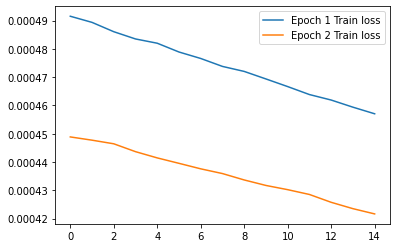

In [ ]:
# loss_tr1 = [l for i, l in enumerate(trainer.state.iter_history["L1Loss"]) if i%2==0]
# loss_tr2 = [l for i, l in enumerate(trainer.state.iter_history["L1Loss"]) if i%2!=0]

# plt.plot(loss_tr1, label = "Epoch 1 Train loss");
# plt.plot(loss_tr2, label = "Epoch 2 Train loss");
# plt.legend();
# #plt.plot(trainer.state.past_iter_history["L1Loss"]);

Let's see how the model can be loaded into a nussl separation object.

In [ ]:
#@title String fields

Target_instrument = 'Violin' #@param ["Violin", "Bassoon", "Clarinet", "Saxphone"]
Max_mixtures = "10" #@param [1, 10]
Hidden_size = "200" #@param [50, 100, 200]
Num_layers = "2" #@param [1, 2]
Dropout = "0" #@param [0, 0.2, 0.3]
Epoch_length = "25" #@param [10, 25, 30]
Max_epochs = "3" #@param [2, 3]
Leave_song = "1" #@param [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Target_instrument = Target_instrument.lower()

In [ ]:
model_config_str = f"SepModel_{Target_instrument}_MaxMix={Max_mixtures}_HSize={Hidden_size}_NLayers={Num_layers}_Dropout={Dropout}_EpcLen={Epoch_length}_MaxEpc={Max_epochs}"

print(model_config_str)

SepModel_violin_MaxMix=20_HSize=200_NLayers=2_EpcLen=25_MaxEpc=4


In [ ]:
separator = nussl.separation.deep.DeepMaskEstimation(
    nussl.AudioSignal(), model_path = f'Bach10_nussl/models/leaveSong{Leave_song}/'+ model_config_str +'/checkpoints/best.model.pth',
    device=DEVICE,
)
song_output_folder = f'Bach10_nussl/models/leaveSong{Leave_song}/'+ model_config_str

Now, let’s test it on a music mixture to see what it learned!

In [ ]:
!ls

 Bach10		 dsd100-Dataset      MUSDB18WAV
 Bach10_nussl	 EEP-Dataset	    'PHENICX(Anechoic)-Dataset'
 Bach10_Scaper	 ISMIR-Database128   RandomAudio
 Bach10_v1.1	 MUSDB18	     URMP-Dataset


In [ ]:
# test_folder = 'Bach10_nussl/test'

# mix_func_test = MixClosure(test_folder, test_folder, template_event_parameters)
# test_data = nussl.datasets.OnTheFly(mix_func_test, num_mixtures=1, stft_params=stft_params, transform=None, sample_rate=44100)

# item = test_data[0]

# separator.audio_signal = item['mix']
# estimates = separator()
# # Since our model only returns one source, let's tack on the residual (which should be accompaniment)
# estimates.append(item['mix'] - estimates[0])

# viz.show_sources(estimates)

Output hidden; open in https://colab.research.google.com to view.



---



## **Evaluation: Bach 10 Dataset**

We're going to evaluate our model on our test set.

In [ ]:
!ls

 Bach10		 dsd100-Dataset      MUSDB18WAV
 Bach10_nussl	 EEP-Dataset	    'PHENICX(Anechoic)-Dataset'
 Bach10_Scaper	 ISMIR-Database128   RandomAudio
 Bach10_v1.1	 MUSDB18	     URMP-Dataset


**METRICS**
- **SI-SDR**: Scale-invariant source-to-distortion ratio. Higher is better.
- **SI-SIR**: Scale-invariant source-to-interference ratio. Higher is better.
- **SI-SAR**: Scale-invariant source-to-artifact ratio. Higher is better.
- **SD-SDR**: Scale-dependent source-to-distortion ratio. Higher is better.
- **SNR**: Signal-to-noise ratio. Higher is better.
- **SRR**: The source-to-rescaled-source ratio. This corresponds to a term that punishes the estimate if its scale is off relative to the reference. This is an unnumbered equation in [1], but is the term on page 2, second column, second to last line: ||s - alpha*s||**2. s is factored out. Higher is better.
- **SI-SDRi**: Improvement in SI-SDR over using the mixture as the estimate. Higher is better.
- **SD-SDRi**: Improvement in SD-SDR over using the mixture as the estimate. Higher is better.
- **SNRi**: Improvement in SNR over using the mixture as the estimate. Higher is better.


Evaluate the separation from an upload file:

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
custom_test_path = "Bach10_nussl/custom_test"
if not os.path.exists(custom_test_path):
        os.makedirs(custom_test_path)
        print("Directory " , custom_test_path ,  " Created ")

!mv uploaded.fn custom_test_path

Evaluate and visualize the estimates sources:

In [ ]:
# Generates something like: bassoon+clarinet+saxphone
concat_instr_str = '+'.join(sum_sources[Target_instrument][0])

tfm = nussl_tfm.Compose([nussl_tfm.SumSources(sum_sources[Target_instrument]),])

test_folder = f'Bach10_nussl_leaveSong{Leave_song}/test'
test_dataset = hooks.MixSourceFolder(folder=test_folder, transform=tfm, stft_params=stft_params)

print(f"Evaluating {Target_instrument} separator vs {concat_instr_str}.")
item = test_dataset[0]
print(item["mix"].path_to_input_file)
separator.audio_signal = item['mix']
estimates = separator()

source_keys = list(item['sources'].keys())
estimates_aux = {
    Target_instrument: estimates[0],
    concat_instr_str: item['mix'] - estimates[0]
}

viz.show_sources(estimates_aux)

sources = [item['sources'][k] for k in source_keys]
estimates = [estimates_aux[k] for k in source_keys]

evaluator = nussl.evaluation.BSSEvalScale(
    sources, estimates, source_labels=source_keys
)

scores = evaluator.evaluate()
song_output_folder = Path(song_output_folder).absolute()
song_output_folder.mkdir(exist_ok=True)

# output_file = output_folder / f"song_{i}.json"
output_file = song_output_folder / sources[0].file_name.replace('wav', 'json')

with open(output_file, 'w') as f:
    json.dump(scores, f, indent=4)

Output hidden; open in https://colab.research.google.com to view.

Now, we can compare the original separated source vs the rest:

In [ ]:
true_song_sources = test_dataset[0]['sources']
viz.show_sources(true_song_sources)

Output hidden; open in https://colab.research.google.com to view.

The script above iterates over items in the test dataset and calculates a lot of metrics for each one. These metrics are saved to JSON files whose name is the same as the name of the item’s filename. We can aggregate all of the metrics into a single report card using nussl:

In [ ]:
!ls

 Bach10		 dsd100-Dataset      MUSDB18WAV
 Bach10_nussl	 EEP-Dataset	    'PHENICX(Anechoic)-Dataset'
 Bach10_Scaper	 ISMIR-Database128   RandomAudio
 Bach10_v1.1	 MUSDB18	     URMP-Dataset


The script above iterates over items in the test dataset and calculates a lot of metrics for each one. These metrics are saved to JSON files whose name is the same as the name of the item’s filename. We can aggregate all of the metrics into a single report card using nussl:

In [ ]:
json_files = glob.glob(f'Bach10_nussl/models/leaveSong{Leave_song}'+ model_config_str +"/*.json")

df = nussl.evaluation.aggregate_score_files(
    json_files, aggregator=np.nanmedian)
nussl.evaluation.associate_metrics(separator.model, df, test_dataset)
report_card = nussl.evaluation.report_card(df, report_each_source=True)
print(report_card)

                                                                                
                             MEAN +/- STD OF METRICS                              
                                                                                
┌────────────┬──────────────────┬────────────────────────────┬──────────────────┐
│ METRIC     │     OVERALL      │ BASSOON+CLARINET+SAXPHONE  │      VIOLIN      │
╞════════════╪══════════════════╪════════════════════════════╪══════════════════╡
│ #          │        2         │             1              │        1         │
├────────────┼──────────────────┼────────────────────────────┼──────────────────┤
│ MIX-SD-SDR │  -0.05 +/-  6.89 │        4.81 +/-   nan      │  -4.93 +/-   nan │
├────────────┼──────────────────┼────────────────────────────┼──────────────────┤
│ MIX-SI-SDR │  -0.05 +/-  6.89 │        4.81 +/-   nan      │  -4.93 +/-   nan │
├────────────┼──────────────────┼────────────────────────────┼──────────────────┤
│ MIX-SNR    │   

### Resultados globales - Comparativa de modelos. 

Métricas: media de los experimentos leave-one out junto a sus correspondientes desviaciones estándar.

|      Modelo     |    SI-SAR    |    SI-SDR    |    SI-SIR    |      SNR     |
|:---------------:|:------------:|:------------:|:------------:|:------------:|
|  Modelo Aum. A  | 3.60 +- 0.03 | 3.60 +- 0.03 | 3.60 +- 0.03 | 3.60 +- 0.03 |
|  Modelo Aum. B  | 3.60 +- 0.03 | 3.60 +- 0.03 | 3.60 +- 0.03 | 3.60 +- 0.03 |
|  Modelo Aum. C  | 3.60 +- 0.03 | 3.60 +- 0.03 | 3.60 +- 0.03 | 3.60 +- 0.03 |
|  Modelo Aum. D  | 3.60 +- 0.03 | 3.60 +- 0.03 | 3.60 +- 0.03 | 3.60 +- 0.03 |
| Modelo NoAum. D | 3.60 +- 0.03 | 3.60 +- 0.03 | 3.60 +- 0.03 | 3.60 +- 0.03 |

### Resultados modelo A - Experimentos Leave-one out 



| Pieza en test |    SI-SAR    |    SI-SDR   | SI-SIR       | SNR          |
|:-------------:|:------------:|:-----------:|--------------|--------------|
|    Pieza 1    |     3.60     |             |              |              |
|    Pieza 2    | 2.76         |             |              |              |
|    Pieza 3    | 1.23         |             |              |              |
|    Pieza 4    |              |             |              |              |
|    Pieza 5    |              |             |              |              |
|    Pieza 6    |              |             |              |              |
|    Pieza 7    |              |             |              |              |
|    Pieza 8    |              |             |              |              |
|    Pieza 9    |              |             |              |              |
|    Pieza 10   |              |             |              |              |
| **Media +- std.** | **2.68 +- 0.30** | **1.8 +- 0.12** | **1.54 +- 0.23** | **4.23 +- 2.34** |



---



Let's save our model after evaluation (**NO SE HACE**):

In [ ]:
# !ls

 Bach10		 dsd100-Dataset      MUSDB18WAV
 Bach10_nussl	 EEP-Dataset	    'PHENICX(Anechoic)-Dataset'
 Bach10_Scaper	 ISMIR-Database128   RandomAudio
 Bach10_v1.1	 MUSDB18	     URMP-Dataset


In [ ]:
# separator.model.save(model_dirName + '/checkpoints/best.model.pth')

'Bach10_nussl/models/baseModel_epoch-length10_max-epochs=2/checkpoints/best.model.pth'

In [ ]:
# model_checkpoint = torch.load(model_dirName + '/checkpoints/best.model.pth')

In [ ]:
# model_checkpoint['metadata'].keys()

dict_keys(['config', 'nussl_version', 'evaluation', 'test_dataset'])

In [ ]:
# model_checkpoint['metadata']['evaluation']

{'MIX-SD-SDR': {'mean': -0.05839279049408219,
  'median': -0.05839279049408219,
  'std': 4.877600043371577},
 'MIX-SI-SDR': {'mean': -0.05824968218803406,
  'median': -0.05824968218803406,
  'std': 4.877601116895676},
 'MIX-SNR': {'mean': 1.4901161193847656e-07,
  'median': 1.4901161193847656e-07,
  'std': 4.847962707281113},
 'SD-SDR': {'mean': -2.1320761041544314,
  'median': -2.1320761041544314,
  'std': 7.058626554800832},
 'SD-SDRi': {'mean': -2.073683313660349,
  'median': -2.073683313660349,
  'std': 2.1810265114292555},
 'SI-SAR': {'mean': 8.010801486670971,
  'median': 8.010801486670971,
  'std': 7.05861646682024},
 'SI-SDR': {'mean': 1.3601841032505035,
  'median': 1.3601841032505035,
  'std': 4.220130294561386},
 'SI-SDRi': {'mean': 1.4184337854385376,
  'median': 1.4184337854385376,
  'std': 0.6574708223342896},
 'SI-SIR': {'mean': 2.786134500056505,
  'median': 2.786134500056505,
  'std': 3.3123951964080334},
 'SNR': {'mean': 4.172697141766548,
  'median': 4.17269714176654



---

